In [3]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from sklearn.cluster import KMeans, AgglomerativeClustering

%matplotlib inline
%load_ext autoreload
%autoreload 2

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [12]:
def pca_and_view(input_arr, num_components=12, 
                 plot=True,
                 figsize=(15,10), 
                 xlabel1="nodes", 
                 ylabel1="components", 
                 title1="'Eigenvectors' of covariance matrix",
                 ylabel2="components", 
                 xlabel2="explained variance ratio", 
                 title2="'Eigenvalues'"):
    pca_model = PCA(n_components=num_components, random_state=0)
    transformed_input = pca_model.fit_transform(input_arr)
    if plot:
        fig,axes = plt.subplots(1,1,figsize=figsize, squeeze=True)
        to_plot = pca_model.components_
        aspect_r = to_plot.shape[1]/to_plot.shape[0]/3.
        #im = axes.imshow(to_plot, origin='left', aspect=aspect_r)
        im = axes.imshow(to_plot, origin='left')
        axes.set_xlabel(xlabel1)
        axes.set_ylabel(ylabel1)
        axes.set_title(title1)
        div = make_axes_locatable(axes)
        cax = div.append_axes("right", size="3%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax0 = div.append_axes("left", size=2, pad=0.1)

        ax0.plot(pca_model.explained_variance_ratio_, np.arange(num_components), 'x-')
        ax0.set_xlabel(xlabel2)
        ax0.set_ylabel(ylabel2)
        ax0.set_title(title2)

    return (pca_model, transformed_input)

def view_pca_2(pca_model, show_shape=(3,3), punit=3, logscale=True): 
    num_comp_to_show = show_shape[0]*show_shape[1] 

    fig1 = plt.figure("PCA1", figsize=(3*show_shape[0], 2))
    plt.plot(pca_model.explained_variance_ratio_, 'k-x')
    plt.xlabel('PCA components')
    plt.ylabel('explained variance ratio')
    if logscale:
        plt.yscale('log')

def view_some_observations(in_obs, view_sh=(2,2), punit=2):
    num_obs = len(in_obs)
    num_to_view = view_sh[0]*view_sh[1]
    locs_to_view = np.random.choice(range(num_obs), num_to_view, replace=False) 
    fig, axes = plt.subplots(*view_sh, figsize=(2*punit*view_sh[0], punit*view_sh[1]))
    for n,ax in zip(locs_to_view, axes.ravel()):
        ax.plot(in_obs[n])
        
def my_single_imshow(to_plot, myfiglabel="generic_label", 
                     figsize=(6,6),
                     xlabel="",ylabel="",title=""):
    """
    Imshow that configures input array to aspect ratio 1,
    and adds colorbar to the right.
    
    Parameters
    ----------
    to_plot     : 2D numpy array
    figsize     : tuple (x,y) , optional
    myfiglabel  : string, optional
    xlabel      : string, optional
    ylabel      : string, optional
    title       : string, optional
    
    """
    aspect_r = to_plot.shape[1]/to_plot.shape[0]
    fig = plt.figure(myfiglabel, figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(1,1), 
                   axes_pad=0.1, cbar_mode='single')
    grid[0].set_xlabel(xlabel)
    grid[0].set_ylabel(ylabel)
    grid[0].set_title(title)
    im = grid[0].imshow(to_plot, aspect=aspect_r, cmap='rainbow_r')
    plt.colorbar(im, cax=grid.cbar_axes[0])

------
# Creating the "puzzle".
**Creating modes.**
- Create $M_\text{mode}$ hidden modes, ${\bf v_m}$, where $m=0, \dots, M_\text{mode}-1$.
- Each mode (say the first mode ${\bf m}_0$ for instance) has a fixed length of $N$ `pixels'.

**Create measurements.**
- Now we create $M_\text{data}$ measurements from these modes: $\mathbf{K}_d$, where $d=0,\ldots,M_\text{data}-1$. 
- Each measurement is a random combination of these modes. 
- For example, the $d$th measurement can be written as
$$ \mathbf{K}_d = \sum_m c_{dm} v_m\;, $$
where $c_{dm}$ are the **modal weights** for the $d$th measurement.

# The objectives.
1. From only this long list of observations ($\mathbf{K}_d$) infer *the number* of hidden modes.
2. Infer what these modes might be. 
3. Play around to see what else you can find. Change the various parameters here, guess what should happen, then execute the code to see if it does what you think it'll do!
4. There are many more decomposition tools in scikit-learn besides PCA and ICA. Try them out!

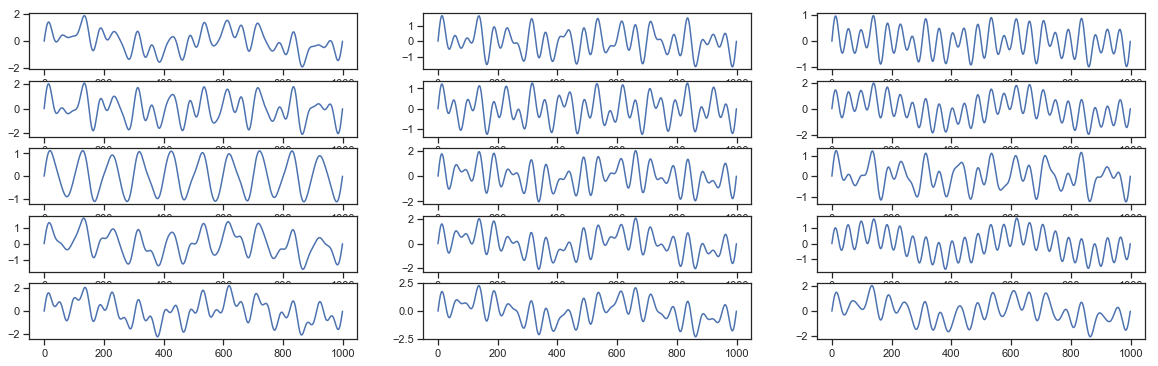

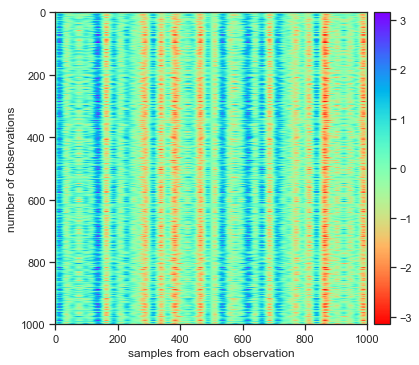

In [77]:
(n_modes, mode_len, n_obs) = (4, 1000, 1000)

mode_time_axis = np.linspace(0, 2*np.pi, mode_len)
freq_list = [2,10,17,23]
hidden_modes = np.vstack([np.sin(f*mode_time_axis) for f in freq_list])

#Uncomment the two lines below to turn on "evil mode"
#hidden_modes = np.random.rand(n_modes, mode_len)
#hidden_modes = np.asarray([np.convolve(v, np.ones(10), 'same') for v in hidden_modes])

obs_mode_weights = np.random.rand(n_obs, n_modes)
obs = np.matmul(obs_mode_weights, hidden_modes)

view_some_observations(in_obs=obs, view_sh=(5,3))

my_single_imshow(obs, myfiglabel="Observations", ylabel='number of observations', xlabel='samples from each observation')

#### Using PCA we can detect the number of hidden modes. 
- This works because PCA identifies the number of independent degrees of freedom. 
- While the modes reconstructed by PCA are orthogonal but not necessarily the correct ones.
- However, the PCA modes are still a decent basis for classifying observations.

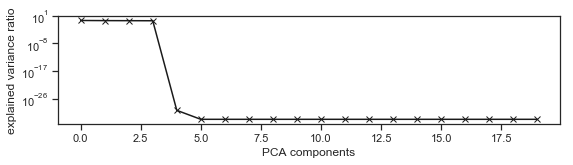

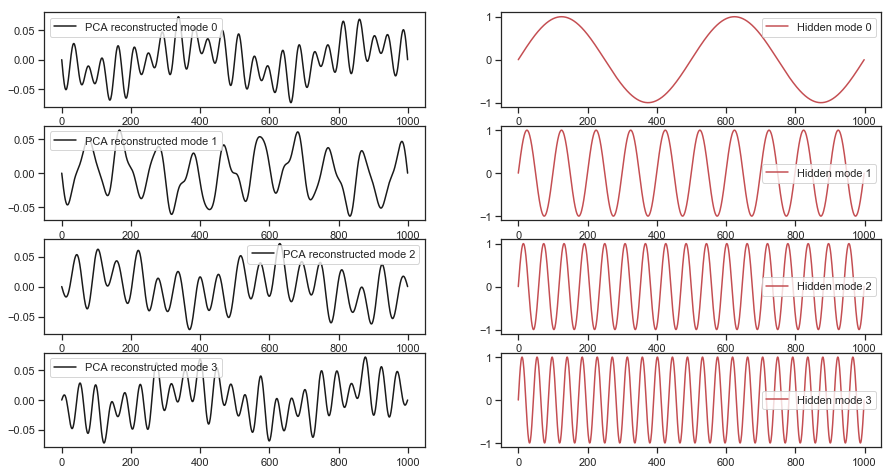

In [78]:
(pca_model, pca_transformed_obs) = pca_and_view(obs, num_components=20,plot=False)
view_pca_2(pca_model)

fig, axes = plt.subplots(n_modes, 2, figsize=(15, 2*n_modes))

for n, (tp, ax) in enumerate(zip(pca_model.components_, axes[:,0])):
    ax.plot(tp, 'k', label='PCA reconstructed mode {:d}'.format(n))
    ax.legend()

for n, (tp, ax) in enumerate(zip(hidden_modes, axes[:,1])):
    ax.plot(tp, 'r', label='Hidden mode {:d}'.format(n))
    ax.legend()

## We can also determine which PCA-recovered mode most closely corresponds to which actual hidden mode. 
Here we compute the Pearson correlation (implemented as ```np.corrcoef```) between the PCA mode and the hidden modes to decide the best correspondence betwen these two sets of modes.

**Questions**
- From the pair correlations plotted below, can you tell that the PCA modes are still mixtures of the actual hidden modes?

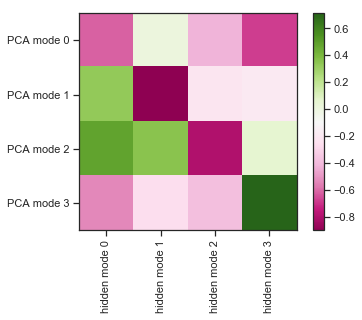

In [79]:
to_plot = np.asarray([np.corrcoef(a,b)[0,1] for a in pca_model.components_[:n_modes] for b in hidden_modes]).reshape(-1,n_modes)
plt.imshow(to_plot, cmap='PiYG')
plt.xticks(range(n_modes), ['hidden mode {:d}'.format(d) for d in range(n_modes)], rotation=90)
plt.yticks(range(n_modes), ['PCA mode {:d}'.format(d) for d in range(n_modes)])
plt.colorbar()

## Notice the PCA reconstructed mode weights correlate with the actual mode weights. 
- However, because the PCA modes are not guaranteed to match the actual hidden modes, this correlation is not perfect. 

**Questions**
- Why are the boundaries some of the pair-plots below "blockish"? 

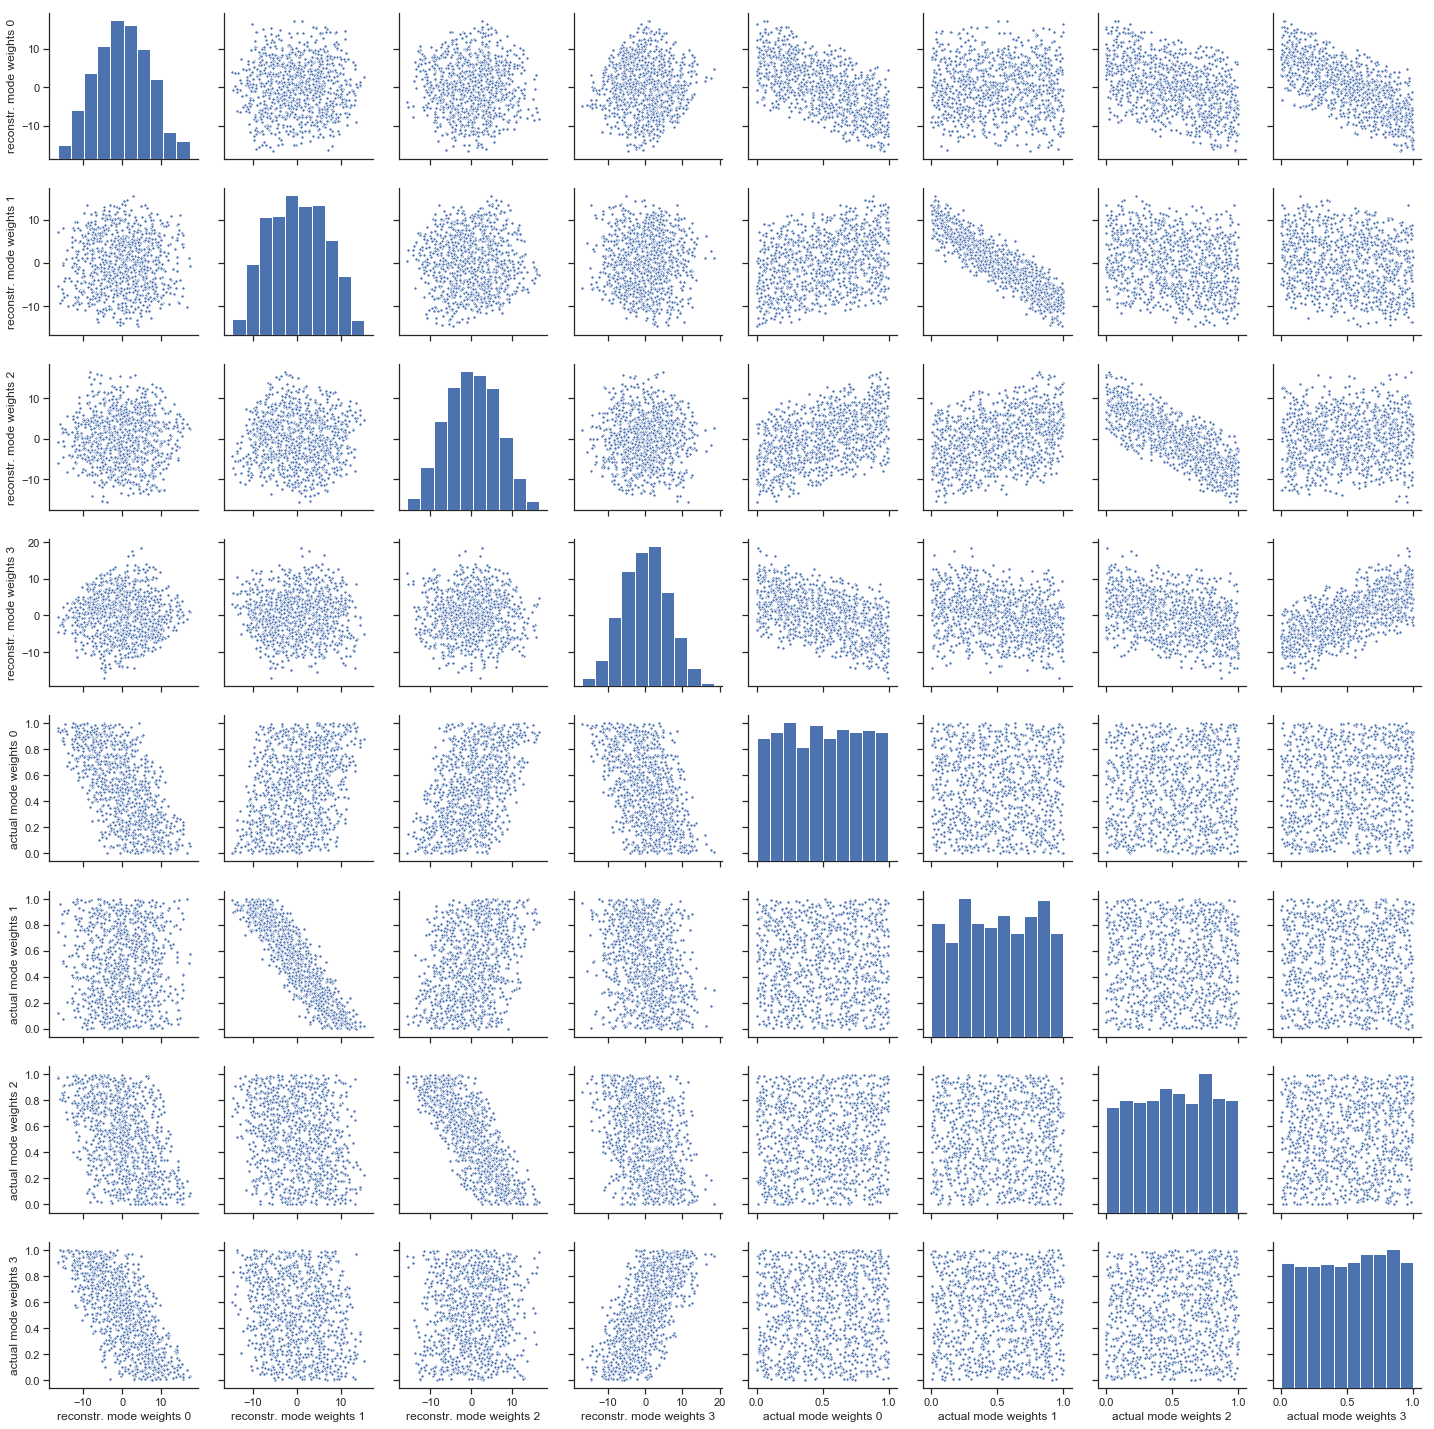

In [81]:
num_comp_to_show = 4
df = pd.DataFrame(pca_transformed_obs[:,:num_comp_to_show])
df.columns = ["reconstr. mode weights {:d}".format(i) for i in range(num_comp_to_show)]
for n,m in enumerate(obs_mode_weights.T):
    df['actual mode weights {:d}'.format(n)] = m.copy()
g = sns.pairplot(df,  plot_kws={"s":10})

## Now we try decomposition using Independent Component Analysis (ICA). 
- ICA finds mixtures of the observations that are mutually independent (in the statistical sense). 
- This decomposition, if given enough observations, tends to recover the hidden states that are **sufficiently distinguishable** (tricky to define what sufficient means here).
- **What happens when you give FastICA the wrong number of components**?

In [84]:
ica_transformer = FastICA(n_components=4, random_state=0)
ica_transformed_obs = ica_transformer.fit_transform(obs)

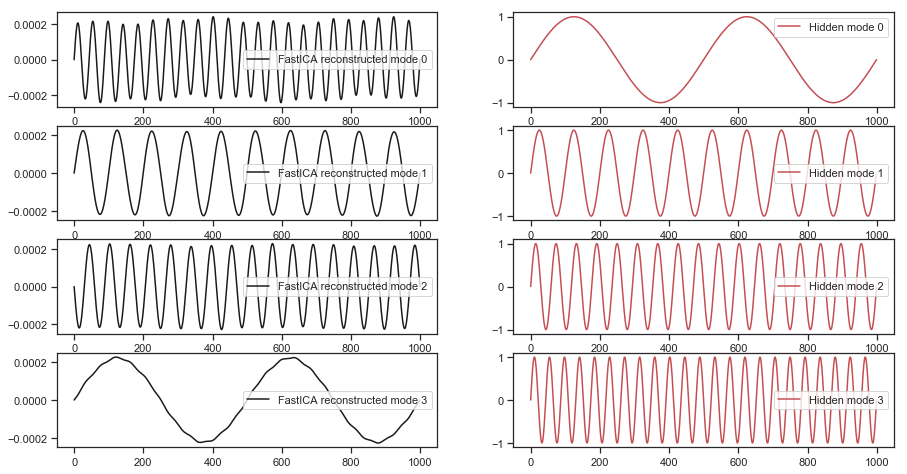

In [85]:
fig, axes = plt.subplots(n_modes, 2, figsize=(15, 2*n_modes))

for n, (tp, ax) in enumerate(zip(ica_transformer.components_, axes[:,0])):
    ax.plot(tp, 'k', label='FastICA reconstructed mode {:d}'.format(n))
    ax.legend()

for n, (tp, ax) in enumerate(zip(hidden_modes, axes[:,1])):
    ax.plot(tp, 'r', label='Hidden mode {:d}'.format(n))
    ax.legend()

## Registering ICA reconstructed modes and actual hidden modes.
- Each observations can be recast into a compact set of weights for the reconstructed modes. 
- The weights for each observation indicate the mixture of reconstructed modes that best match the observation. 

**Questions**
- What does it mean if the correlations computed using ```np.corrcoef``` below are negative?

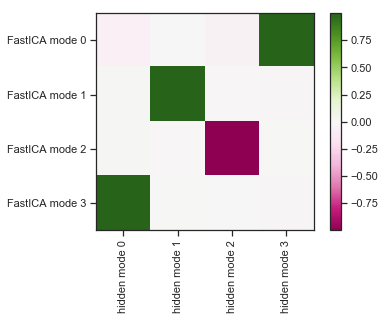

In [87]:
to_plot = np.asarray([np.corrcoef(a,b)[0,1] for a in ica_transformer.components_ for b in hidden_modes]).reshape(-1,len(hidden_modes))
plt.imshow(to_plot, cmap='PiYG')
plt.xticks(range(n_modes), ['hidden mode {:d}'.format(d) for d in range(n_modes)], rotation=90)
plt.yticks(range(n_modes), ['FastICA mode {:d}'.format(d) for d in range(n_modes)])
plt.colorbar()

### Correlation plots between ICA recovered mode weights and actual mode weights helps register these two sets of modes together.

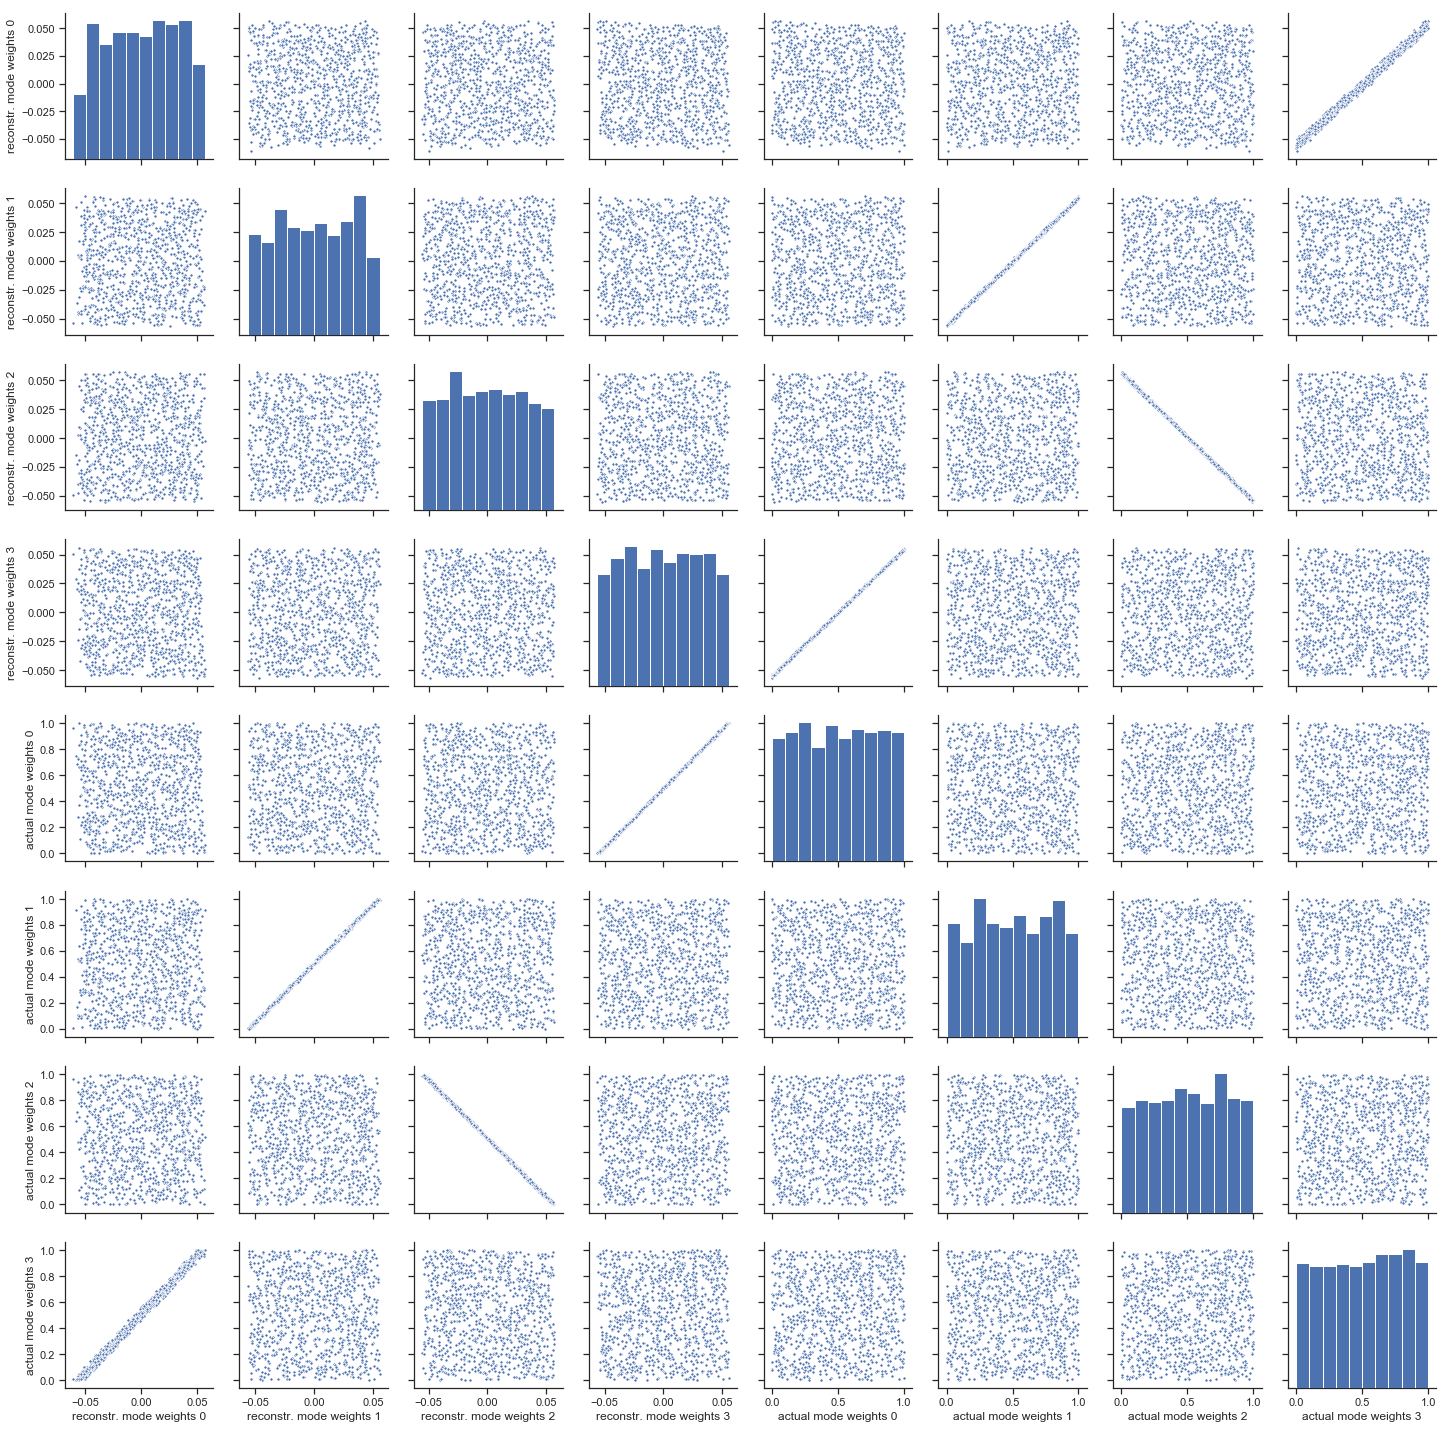

In [89]:
num_comp_to_show = 5
df = pd.DataFrame(ica_transformed_obs)
df.columns = ["reconstr. mode weights {:d}".format(i) for i in range(len(ica_transformed_obs.T))]
for n,m in enumerate(obs_mode_weights.T):
    df['actual mode weights {:d}'.format(n)] = m.copy()
g = sns.pairplot(df,  plot_kws={"s":10})

------
# Fancier methods. 
Unsure they help.

## t-distributed Stochastic Neighbor Embedding (tSNE).

In [42]:
node_position_model = TSNE(n_components=2, init='pca', perplexity=20)
embedding = node_position_model.fit_transform(obs)
kmeans = KMeans(n_clusters=20, random_state=0).fit(embedding)

In [43]:
ACmodel = AgglomerativeClustering(n_clusters=20)
ACmodel = ACmodel.fit(obs)

Text(0.5,1,'TSNE perplexity 20')

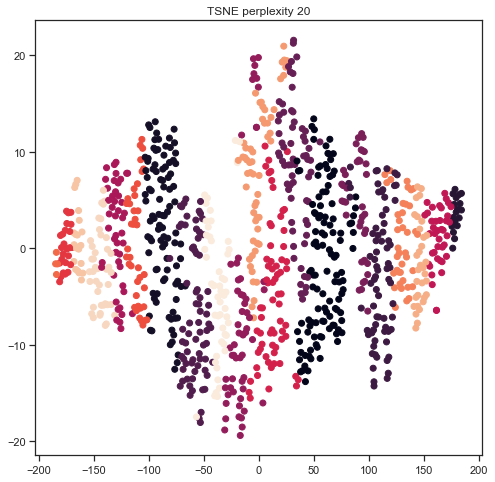

In [45]:
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:,1], c=ACmodel.labels_)
plt.title("TSNE perplexity {:d}".format(20))

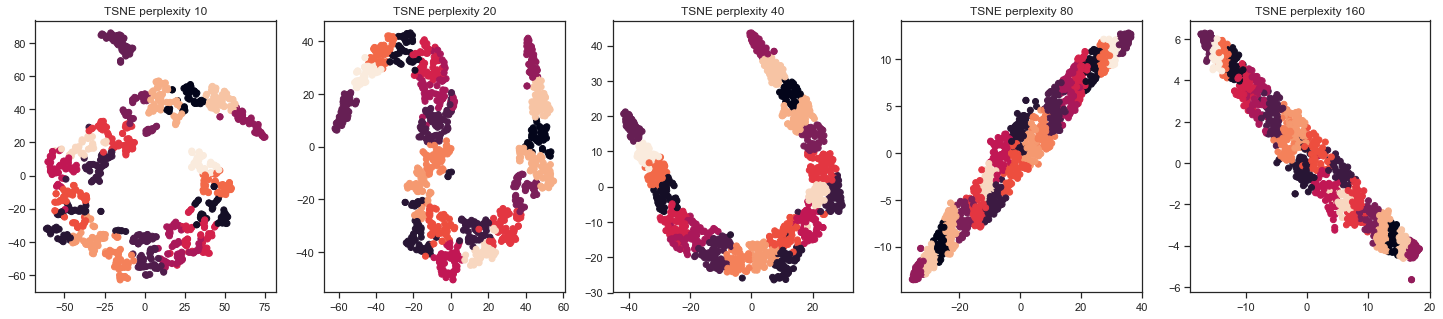

In [46]:
fig,axes = plt.subplots(1,5, figsize=(25,5))

for p,ax in zip([10,20,40,80,160], axes.ravel()):
    node_position_model = TSNE(n_components=2, init='random', perplexity=p)
    embedding = node_position_model.fit_transform(obs)

    ax.scatter(embedding[:,0], embedding[:,1], c=kmeans.labels_)
    ax.set_title("TSNE perplexity {:d}".format(p))

## Agglomerative clustering.

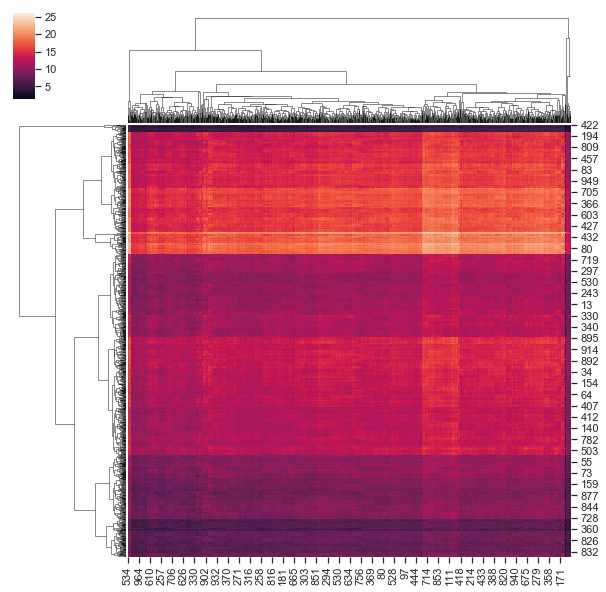

In [47]:
sns.clustermap(obs)